# Does Noise Amplification affect VQE Computations?
For Extrapolation to be useful, this condition has to be met.

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

noise_models = []

for i in range(5):
    #scaling probabilities 
    prob_1 = (i+1)*0.001
    prob_2 = (i+1)*0.01
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    noise_models.append(noise_model)


Running on a sample circuit

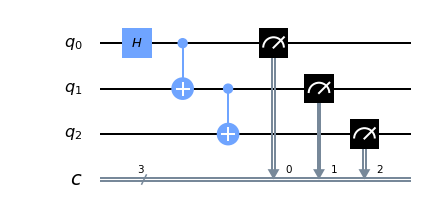

In [2]:

# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

circ.draw(output = 'mpl')

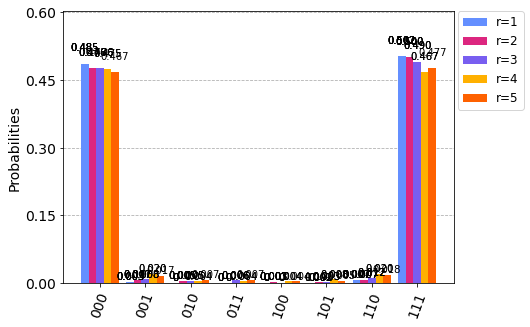

In [3]:
#running all results on a simulator
simulator = Aer.get_backend('qasm_simulator')

counts = []
for noise_model in noise_models:
    sim_result = execute(circ, backend=simulator, noise_model = noise_model, shots=1024).result()
    counts.append(sim_result.get_counts(circ))
plot_histogram([counts[0], counts[1], counts[2], counts[3], counts[4]], legend=['r=1', 'r=2','r=3','r=4','r=5' ])

# VQE with different noise scalings

In [4]:
# Set up VQE
#Doing away with all libraries
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries


from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram
    

In [5]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [6]:
#Begin VQE

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA

# Specifying whether running code on a simulator or an actual quantum device
backend = Aer.get_backend("qasm_simulator")
# creating a list of distances to run VQE on 
distances = np.arange(0.1, 2, 0.1)
exact_energies = []
vqe_energies = []
vqe_ideal_energy = []
#adding empty boxes for later usage
for i in range(5): 
    vqe_energies.append([])

#Quantum Instances for each noise model 
quantum_instances = []
for noise_model in noise_models:
    quantum_instance = QuantumInstance(backend=backend, 
                                   noise_model=noise_model )
    quantum_instances.append(quantum_instance)

optimizer = COBYLA(maxiter=1000)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
    # Finding exact energies to show how off VQE was from exact energy curve
    result = ExactEigensolver(qubitOp).run()
    exact_energies.append(result['energy'] + shift)
    # Initial STate 
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        'parity'
    ) 
    print(qubitOp.num_qubits)
    # UCCSD Variational Form
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    # Running VQE using a simulator, not actual quantum computer
    vqe = VQE(qubitOp, var_form, optimizer)
    
    #Running Ideal VQE
    resulty = vqe.run(backend)['energy'] + shift
    vqe_ideal_energy.append(resulty)
    
    #running VQE for each noise scaling
    for i in range(5):
        results = vqe.run(quantum_instances[i])['energy'] + shift
        vqe_energies[i].append(results)
        print( str(i)+  " phase done")
    
    print("Interatomic Distance:", np.round(dist, 2), "IdealVQE Result:", resulty, "Exact Energy:", 
          exact_energies[-1])
print("All energies have been calculated")

HF energy: -2.575884715907248
# of electrons: 2
# of spin orbitals: 4
2
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
Interatomic Distance: 0.1 IdealVQE Result: 2.70996079135306 Exact Energy: 2.7099607708672764
HF energy: -2.4817110425383038
# of electrons: 2
# of spin orbitals: 4
2
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
Interatomic Distance: 0.2 IdealVQE Result: 0.15748214003518024 Exact Energy: 0.15748213479836615
HF energy: -2.357751794935727
# of electrons: 2
# of spin orbitals: 4
2
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
Interatomic Distance: 0.3 IdealVQE Result: -0.60180369850217 Exact Energy: -0.6018037107656864
HF energy: -2.2273044214635394
# of electrons: 2
# of spin orbitals: 4
2
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
Interatomic Distance: 0.4 IdealVQE Result: -0.9141496836168601 Exact Energy: -0.9141497046270808
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 

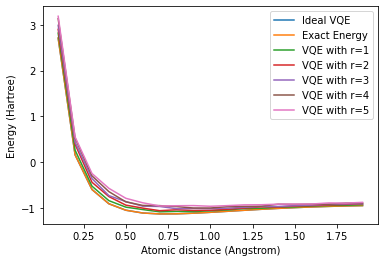

In [29]:
# plotting the data
plt.plot(distances, vqe_ideal_energy, label="Ideal VQE")
plt.plot(distances, exact_energies, label="Exact Energy")

plt.plot(distances, vqe_energies[0], label="VQE with r=1")
plt.plot(distances, vqe_energies[1], label="VQE with r=2")
plt.plot(distances, vqe_energies[2], label="VQE with r=3")
plt.plot(distances, vqe_energies[3], label="VQE with r=4")
plt.plot(distances, vqe_energies[4], label="VQE with r=5")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

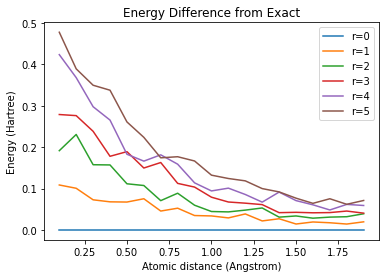

In [30]:
energy_difference= []
for i in range(6): 
    energy_difference.append([])

for i in range(6):
    if (i ==0): 
        for k in range(len(vqe_ideal_energy)):
            energy_difference[i] = energy_difference[i] + [vqe_ideal_energy[k] - exact_energies[k]]
    else:
        for k in range(len(vqe_ideal_energy)):
            energy_difference[i] = energy_difference[i] + [vqe_energies[i-1][k] - exact_energies[k]]


plt.plot(distances, energy_difference[0], label="r=0")
plt.plot(distances, energy_difference[1], label="r=1")
plt.plot(distances, energy_difference[2], label="r=2")
plt.plot(distances, energy_difference[3], label="r=3")
plt.plot(distances, energy_difference[4], label="r=4")
plt.plot(distances, energy_difference[5], label="r=5")



plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()

# Analysis 
The graph suggests that if we scale the depolarizing error higher and higher, our results tend to go away from the exact energy. So noise amplification diverges VQE estimate from actual answer. 

# To do next
Extrapolate

# Linear Extrapolation Using Curve Fitting
Instead of using the equations-method (which I used earlier and messed up ) as shown in section 3 in supplemental materials of Temme Paperm, here I use a simple curve fitting technique. 

How the curve fitting technique works is shown later in this document.

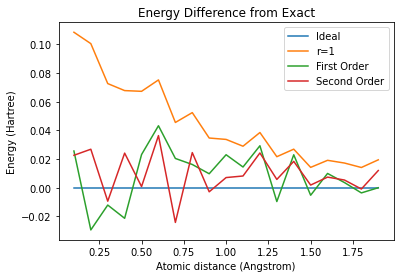

In [31]:
from scipy.optimize import curve_fit
# extrapolating to 4 orders the entire thing through curve fitting 
orders = []
orders_diff =[]
plot = []
for i in range(2,6): 
    #building up orders through curve fitting 
    some_order = []
    for k in range(len(vqe_ideal_energy)):
        plot=[]
        x = np.array([])
        y = np.array([])
        for c in range(i):
            x = np.append(x, [c+1])
            y = np.append(y, [vqe_energies[c][k]])
        plot.append(x)
        plot.append(y)
        def fit_func(x, a, b):
            return a*x + b
        params = curve_fit(fit_func, x, y)
        [a, b] = params[0]
        plot.append([a, b])
        some_order.append(params[0][1])
    orders.append(some_order)
#differences from exact
for order in orders:
    some_diff = []
    for k in range(len(vqe_ideal_energy)):
        some_diff = some_diff + [order[k] - exact_energies[k]]
    orders_diff.append(some_diff)
#plotting energy differences
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, energy_difference[1], label="r=1")
plt.plot(distances, orders_diff[0], label="First Order", color= 'tab:green')
plt.plot(distances, orders_diff[1], label="Second Order", color= 'tab:red')
#plt.plot(distances, orders_diff[2], label="Third Order")
#plt.plot(distances, orders_diff[3], label="Fourth Order")


plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()                          

## Adding in Third Order

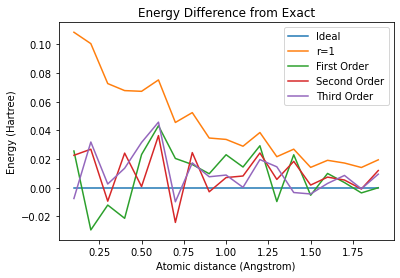

In [32]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, energy_difference[1], label="r=1")
plt.plot(distances, orders_diff[0], label="First Order", color= 'tab:green')
plt.plot(distances, orders_diff[1], label="Second Order", color= 'tab:red')
plt.plot(distances, orders_diff[2], label="Third Order", color = 'tab:purple')
#plt.plot(distances, orders_diff[3], label="Fourth Order")


plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()

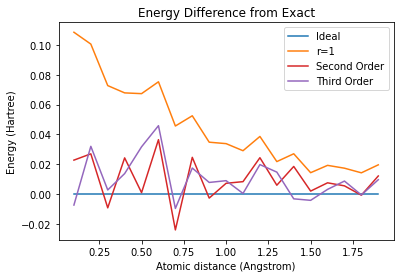

In [33]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, energy_difference[1], label="r=1")
#plt.plot(distances, orders_diff[0], label="First Order", color= 'tab:green')
plt.plot(distances, orders_diff[1], label="Second Order", color= 'tab:red')
plt.plot(distances, orders_diff[2], label="Third Order", color = 'tab:purple')
#plt.plot(distances, orders_diff[3], label="Fourth Order")


plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()

## Fourth Order

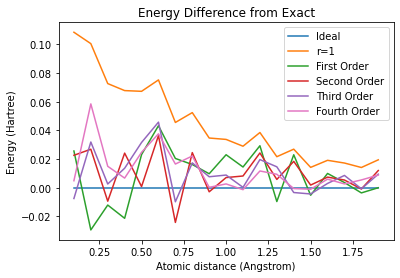

In [34]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, energy_difference[1], label="r=1")
plt.plot(distances, orders_diff[0], label="First Order", color= 'tab:green')
plt.plot(distances, orders_diff[1], label="Second Order", color= 'tab:red')
plt.plot(distances, orders_diff[2], label="Third Order", color = 'tab:purple')
plt.plot(distances, orders_diff[3], label="Fourth Order", color = 'tab:pink')


plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()

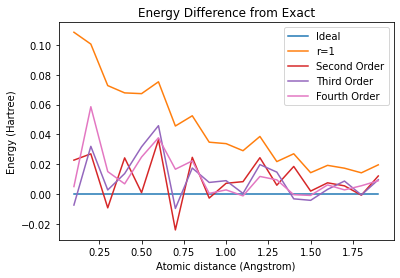

In [35]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, energy_difference[1], label="r=1")
#plt.plot(distances, orders_diff[0], label="First Order", color= 'tab:green')
plt.plot(distances, orders_diff[1], label="Second Order", color= 'tab:red')
plt.plot(distances, orders_diff[2], label="Third Order", color = 'tab:purple')
plt.plot(distances, orders_diff[3], label="Fourth Order", color = 'tab:pink')


plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()

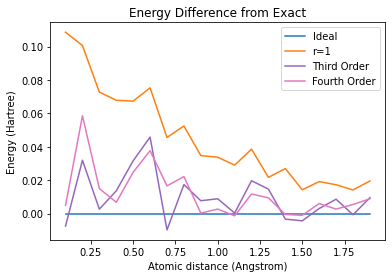

In [36]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, energy_difference[1], label="r=1")
#plt.plot(distances, orders_diff[0], label="First Order", color= 'tab:green')
#plt.plot(distances, orders_diff[1], label="Second Order", color= 'tab:red')
plt.plot(distances, orders_diff[2], label="Third Order", color = 'tab:purple')
plt.plot(distances, orders_diff[3], label="Fourth Order", color = 'tab:pink')


plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()

# How it Works? 

Consider the Graph below titled, "Extrapolating 0 error energy when H atoms are 1.9 angstroms apart." The red dots are the calculated energies when we scale by some factors. Those factors are labeled as "scalings" and this is done by increasing the error probabilities by some amount.

Using a SciPy package, we try to fit a line through those points using least squares. From that line, we extrapolate or extract the zero error solution i.e. if line is y= f(x), then we take out y(0).

Note: I can't connect the line to the blue point(zero error solution). But the blue point does sit on the line

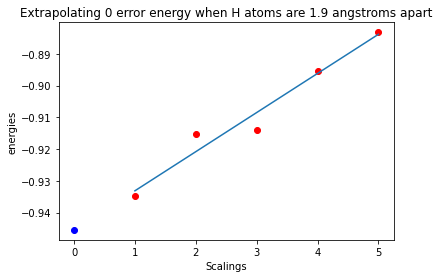

In [37]:
plt.plot(plot[0], plot[1], 'ro')
plt.plot(0, orders[3][18], 'bo')
plt.plot(x, plot[2][0]*x + plot[2][1])
plt.xlabel('Scalings')
plt.ylabel('energies')
plt.title('Extrapolating 0 error energy when H atoms are 1.9 angstroms apart')
plt.show()

## Orders of Extrapolation

First Order: Fitting a line through 2 red points (r=1 and r=2)

Second Order: Fitting a line through 3 red points (r=1, r=2, r=3)

and on and on. 
In the graph above, we are performing a 4th order extrapolation!!

The assumption is that the more red points you have, the better the zero error solution (blue point).

# Exponential Extrapolation

Instead of trying to fit a line through the points, lets try fitting an exponential curve of the form $$a*e^{bx}$$. 

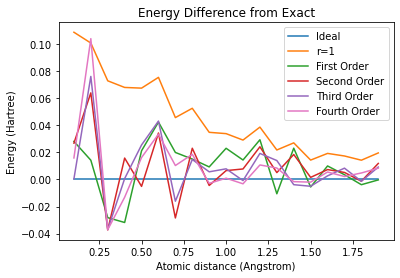

In [38]:
# extrapolating to 4 orders the entire thing through curve fitting 
ex_orders = []
ex_orders_diff =[]
ploty = []
for i in range(2,6): 
    #building up orders through curve fitting 
    some_order = []
    for k in range(len(vqe_ideal_energy)):
        ploty=[]
        x = np.array([])
        y = np.array([])
        for c in range(i):
            x = np.append(x, [c+1])
            y = np.append(y, [vqe_energies[c][k]])
        ploty.append(x)
        ploty.append(y)
        def fit_func(x, a, b):
            return a * np.exp(b * x)  
        params = curve_fit(fit_func, x, y)
        [a, b] = params[0]
        ploty.append([a, b])
        some_order.append(params[0][0])
    ex_orders.append(some_order)
#differences from exact
for order in ex_orders:
    some_diff = []
    for k in range(len(vqe_ideal_energy)):
        some_diff = some_diff + [order[k] - exact_energies[k]]
    ex_orders_diff.append(some_diff)
#plotting energy differences
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, energy_difference[1], label="r=1")
plt.plot(distances, ex_orders_diff[0], label="First Order", color= 'tab:green')
plt.plot(distances, ex_orders_diff[1], label="Second Order", color= 'tab:red')
plt.plot(distances, ex_orders_diff[2], label="Third Order", color = 'tab:purple')
plt.plot(distances, ex_orders_diff[3], label="Fourth Order", color = 'tab:pink')


plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()      

-0.9460324410809242
-0.013554953170051554


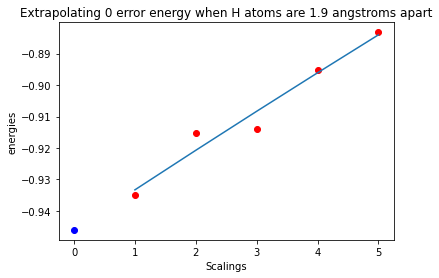

In [39]:
plt.plot(ploty[0], ploty[1], 'ro')
plt.plot(0, ex_orders[3][18], 'bo')
a = ploty[2][0]
b= ploty[2][1]
print(a)
print(b)
plt.plot(x, a*np.exp(b*x))
plt.xlabel('Scalings')
plt.ylabel('energies')
plt.title('Extrapolating 0 error energy when H atoms are 1.9 angstroms apart')
plt.show()

Should look like an exponential curve but the red dots are such that the curve fit package makes the exponential curve look like a line. 

# Comparing Linear Vs Extrapolation Results

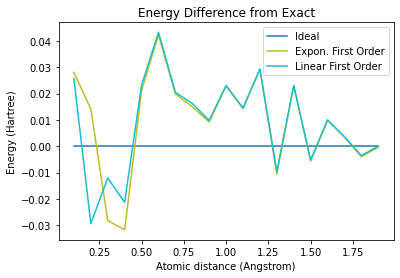

In [40]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, ex_orders_diff[0], label="Expon. First Order", color= 'tab:olive')
plt.plot(distances, orders_diff[0], label="Linear First Order", color= 'tab:cyan')

plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()      

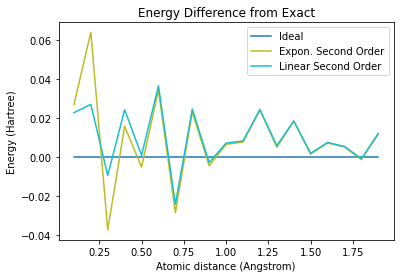

In [41]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, ex_orders_diff[1], label="Expon. Second Order", color= 'tab:olive')
plt.plot(distances, orders_diff[1], label="Linear Second Order", color= 'tab:cyan')

plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()   

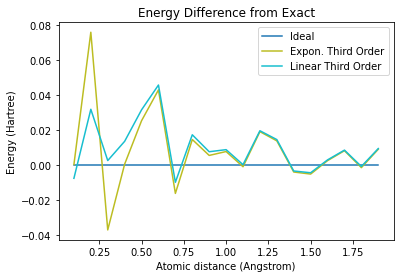

In [42]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, ex_orders_diff[2], label="Expon. Third Order", color= 'tab:olive')
plt.plot(distances, orders_diff[2], label="Linear Third Order", color= 'tab:cyan')

plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()   

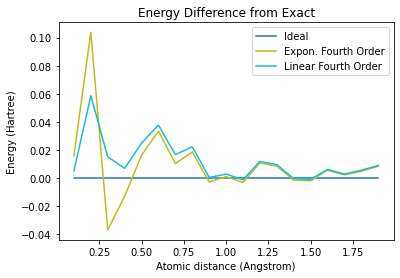

In [43]:
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, ex_orders_diff[3], label="Expon. Fourth Order", color= 'tab:olive')
plt.plot(distances, orders_diff[3], label="Linear Fourth Order", color= 'tab:cyan')

plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()   

# Extrapolating Using Equations

THIS IS NOT WORKING!!!!

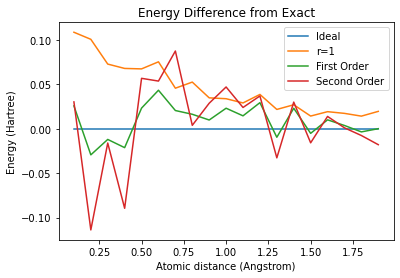

In [49]:
# extrapolating to 4 orders the entire thing through curve fitting 
eq_orders = []
eq_orders_diff = []
#first Order
f_order = []
for i in range(len(vqe_ideal_energy)):
    answer = 2*(vqe_energies[0][i])-(vqe_energies[1][i])
    f_order.append(answer)
eq_orders.append(f_order)
#second order 
s_order = []
for i in range(len(vqe_ideal_energy)):
    answer = (3*(vqe_energies[0][i]))-(3*(vqe_energies[1][i]))+vqe_energies[2][i]
    s_order.append(answer)
eq_orders.append(s_order)
#third order
t_order = []
for i in range(len(vqe_ideal_energy)):
    answer = (4*(vqe_energies[0][i]))-(6*(vqe_energies[1][i]))+(4*vqe_energies[2][i])-vqe_energies[3][i]
    t_order.append(answer)
eq_orders.append(t_order)
#fourth order
fo_order = []
for i in range(len(vqe_ideal_energy)):
    answer = (5*(vqe_energies[0][i]))-(10*(vqe_energies[1][i]))+(10*vqe_energies[2][i])-(5*vqe_energies[3])+ (1*vqe_energies[4])                [i]
    fo_order.append(answer)
eq_orders.append(fo_order)
#differences from exact
for order in eq_orders:
    some_diff = []
    for k in range(len(vqe_ideal_energy)):
        some_diff = some_diff + [order[k] - exact_energies[k]]
    eq_orders_diff.append(some_diff)
#plotting energy differences
plt.plot(distances, energy_difference[0], label="Ideal")
plt.plot(distances, energy_difference[1], label="r=1")
plt.plot(distances, eq_orders_diff[0], label="First Order", color= 'tab:green')
plt.plot(distances, eq_orders_diff[1], label="Second Order", color= 'tab:red')
#plt.plot(distances, eq_orders_diff[2], label="Third Order", color = 'tab:purple')
#plt.plot(distances, eq_orders_diff[3], label="Fourth Order", color = 'tab:pink')


plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Difference from Exact')
plt.legend()
plt.show()      